# Summary of this notebook
This notebook introduces the evaluation framework. It compares the generated json to the original json (ground truth) and calculates a similarity score. First, the evaluation is calculated on one example to illustrate the usage of the framework (Chapter Calculating BPMN similarity for one example). Then the steps of the evaluation are further explained. First the models are broken down element wise into lists (Chapter How it works part 1: Component Wise Breakdown). Then similar items in the list are replaced to allow syntactical derivations (Chapter How it works part 2: Making similar items in the lists equal). Afterthat, the lists are indexed to allow measuring the frequency of items (Chapter How it works part 3: Indexing lists for frequency awareness). Finally the similarity of each list-pair is caluclated with the dice metric, jaccard is also available (How it works part 4: Calcaulating the similarity of the two lists). The evaluation framework is applied to the generated models and the results are presented (Chapter Applying the framework to the generated models and the dataset).

# Calculating BPMN similarity for one example

We want to evaluate the generated JSON and compare it to the ground truth json. Lets calculate the BPMN similarity for one example.

In [1]:
import json
from multimodalgenai.evaluation import bpmn_similarity

# load ground truth from examples
filename_ground_truth = f"../data/examples/ground-truth.json"
with open(filename_ground_truth, 'r') as infile:
    ground_truth = json.load(infile)

# load generated from examples
filename_generated = f"../data/examples/generated.json"
with open(filename_generated, 'r') as infile:
    generated = json.load(infile)

print(ground_truth)
print(generated)
# results in an overall similarity of 49 percent. 
# the similarity is broken down in more fine-grained scores, for example for tasks and task names.
print(bpmn_similarity.calculate_similarity_scores(ground_truth, generated)) 

c:\Users\I566116\AppData\Local\anaconda3\envs\multimodalgenai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'tasks': [{'id': 'sid-FFF7A601-D7E5-4061-8409-146F24B72F13', 'name': 'Invite to job interview', 'type': 'Task'}, {'id': 'sid-53C132C5-359D-4E79-8FBB-99B7C41973C7', 'name': 'Prepare employment agreement', 'type': 'Task'}, {'id': 'sid-CAF14C6A-837F-417D-B67A-2A7B6362B5DB', 'name': 'Send receipt confirmation', 'type': 'Task'}, {'id': 'sid-18206754-99AE-4C11-B9A7-BEB27E81FED5', 'name': 'Send employment contract', 'type': 'Task'}, {'id': 'sid-31C0CE32-8227-44E5-B7F0-0501D5D57FB4', 'name': 'Send rejection', 'type': 'Task'}, {'id': 'sid-F7A0EA5F-240D-433C-A911-C815B73F9A3F', 'name': 'Verify applicant', 'type': 'Task'}, {'id': 'sid-6CCC5A9A-2512-4C46-93EB-90B1CDD0FFEC', 'name': 'Carry out job interview', 'type': 'Task'}], 'events': [{'id': 'sid-25311BE5-F820-4CB8-B325-EA5EA5E655AD', 'name': 'Application received', 'type': 'StartMessageEvent'}, {'id': 'sid-1809C426-6409-43F2-AD67-66E163ACA06F', 'name': 'Signed employment  contract is present', 'type': 'EndNoneEvent', 'outgoing': []}, {'id': 's

# How it works part 1: Component Wise Breakdown
The function calculate_similarity_scores first breaks down the two models into multiple lists. Namely list of task names, task types, event names, event types, gateway names, gateway types, pools and lanes, message flow, and sequence flow. Adding the message and sequence flows makes the function aware of the control flow and the connections of the elements to each other.


In [5]:
# lets do this exemplarily for the task names
ground_truth_task_names = list(map(lambda t: t["name"], ground_truth["tasks"]))
generated_task_names = list(map(lambda t: t["name"], generated["tasks"]))
print(ground_truth_task_names)
print(generated_task_names)

['Invite to job interview', 'Prepare employment agreement', 'Send receipt confirmation', 'Send employment contract', 'Send rejection', 'Verify applicant', 'Carry out job interview']
['Send receipt confirmation', 'Applicant verified', 'Invite to job interview', 'Prepare employment agreement', 'Carry out job interview', 'Send employment contract', 'Send rejection']


In [4]:
# and for lanes. For lanes we have two different lists:
# lanes: includes only the concatenaded name of the pool and lane
# lanes with refs: additionally concatentinates the referenced elements
from multimodalgenai.bpmn_schema_helper import get_lanes
lanes, lanes_with_refs = get_lanes(ground_truth)
print(lanes)
print(lanes_with_refs)

['Company - Human Resources Department', 'Company - Head of Human Resources', 'Applicant']
['Company - Human Resources Department - Invite to job interview', 'Company - Human Resources Department - Prepare employment agreement', 'Company - Human Resources Department - Send receipt confirmation', 'Company - Human Resources Department - Send employment contract', 'Company - Human Resources Department - Send rejection', 'Company - Human Resources Department - Application received', 'Company - Human Resources Department - Signed employment  contract is present', 'Company - Human Resources Department - Signed employment contract received', 'Company - Human Resources Department - Exclusive_Databased_Gateway', 'Company - Head of Human Resources - Verify applicant', 'Company - Head of Human Resources - Carry out job interview', 'Company - Head of Human Resources - Rejection sent', 'Company - Head of Human Resources - Applicant rejected', 'Company - Head of Human Resources - Exclusive_Databased

In [6]:
# for the flows the function takes the target value, the source value and the optional label and concatinates them
from multimodalgenai.bpmn_schema_helper import get_flows_with_values
gt_seq_flow_with_values, gt_mes_flow_with_values = get_flows_with_values(ground_truth)
gen_seq_flow_with_values, gen_mes_flow_with_values = get_flows_with_values(generated)

# transform the values into strings
gt_seq_flows_str = list(map(lambda e: " ".join(e), gt_seq_flow_with_values))
gen_seq_flows_str = list(map(lambda e: " ".join(e), gen_seq_flow_with_values))
gt_seq_flows_str, gen_seq_flows_str

(['Verify applicant  Exclusive_Databased_Gateway',
  'Invite to job interview  Prepare employment agreement',
  'Application received  Send receipt confirmation',
  'Send receipt confirmation  Verify applicant',
  'Rejection sent  Exclusive_Databased_Gateway',
  'Prepare employment agreement  Carry out job interview',
  'Carry out job interview  Exclusive_Databased_Gateway',
  'Send employment contract  Signed employment contract received',
  'Exclusive_Databased_Gateway  Send employment contract',
  'Exclusive_Databased_Gateway  Send rejection',
  'Exclusive_Databased_Gateway  Invite to job interview',
  'Exclusive_Databased_Gateway  Rejection sent',
  'Signed employment contract received  Signed employment  contract is present',
  'Send rejection  Exclusive_Databased_Gateway',
  'Exclusive_Databased_Gateway  Applicant rejected'],
 ['Receipt of application  Send receipt confirmation',
  'Send receipt confirmation  Exclusive Gateway',
  'Exclusive Gateway positive evaluation Applicant 

# How it works part 2: Making similar items in the lists equal
Now each list pair (L1,L2) is independently processed, for example the generated task names as L1 and the ground truth task names as L2. Items in L2 beyond a similarity threshold in L2 are made identical to L1. That allows syntactical deviations of the items when the meaning is still the same. An item can be matched as similar only ones and is matched similar with the item from the opponent list, which has the highest available similarity score. That prevents an inflation of replacements.

In [7]:
# Lets look at some examples
from multimodalgenai.evaluation.string_similarity import bert_cosine_optimized
from multimodalgenai.evaluation.list_similarity import make_similar_items_equal

def print_example(list1, list2):
    list1_replaced, list2_replaced = make_similar_items_equal(list1, list2, bert_cosine_optimized, 0.7)
    print(list1_replaced, "\n", list2_replaced, "\n")

# nothing changes, as nothing is similar enough (lion and lion is but we dont see a change because they are already equal)
list1 = ["Lion" , "Tiger" , "Cheetah" , "Leopard" , "Rhino"]
list2 = ["Lion", "Monkey", "Cheetah","Cat", "Dog",]
print_example(list1, list2)

# but when we change lion and cheetah a bit its still matched and replaced!
list1 = ["A Lion" , "One Tiger" , "Cheetah" , "Leopard" , "Rhino"]
list2 = ["Lion", "Monkey","A Cheetah","Cat","Dog"]
print_example(list1, list2)

# another example with semantical similarity
list1 = ["We saw a Lion" , "We have called a Lion"]
list2 = ["Calling a lion", "Seeing a lion", "", "Monkey"]
print_example(list1, list2)

# this example shows that the most similar items are matched and no double matching is allowed. 
# a lion is more similar to two lions than to three lions
list1 = ["We saw a Lion in the forest"]
list2 = ["We saw three Lions in the forest", "We saw two Lions in the forest", ]
print_example(list1, list2)

# but when two lions is not available it will match with three instead if still above the threshold
list1 = ["We saw a Lion in the forest"]
list2 = ["We saw three Lions in the forest"]
print_example(list1, list2)

['Lion', 'Tiger', 'Cheetah', 'Leopard', 'Rhino'] 
 ['Lion', 'Monkey', 'Cheetah', 'Cat', 'Dog'] 

['A Lion', 'One Tiger', 'Cheetah', 'Leopard', 'Rhino'] 
 ['A Lion', 'Monkey', 'Cheetah', 'Cat', 'Dog'] 

['We saw a Lion', 'We have called a Lion'] 
 ['We have called a Lion', 'We saw a Lion', '', 'Monkey'] 

['We saw a Lion in the forest'] 
 ['We saw three Lions in the forest', 'We saw a Lion in the forest'] 

['We saw a Lion in the forest'] 
 ['We saw a Lion in the forest'] 



For measuring the similarity of two items in the list we need a similarity function for two strings. We experimented with two: tfid_cosine (ignores context but faster) and bert_cosine(context aware but slower). Other measures like editing distance or the use of a synonmyms glossary would be other options. bert_cosine seems to be the most precise measuring semantic simialirty. Therefore we take an optimized version of bert which caches old requests making it more efficient for repeated calculations.

In [2]:
# some experiments and comparisons of bert and tfid
from multimodalgenai.evaluation.string_similarity import tfid_cosine, bert_cosine_optimized

print(tfid_cosine("Verify applicant", "Applicant verified")) # tfid works great when the words are the same
print(tfid_cosine("Verify applicants", "Applicant verified")) # but adding a letter to the word already changes the measure
print(bert_cosine_optimized("Verify applicants", "Applicant verified")) # bert is less sensitive for that but it also takes longer to compute
print(bert_cosine_optimized("'Applicant suitable?0", "Applicant suitable0")) # bert is less sensitive for that but it also takes longer to compute

0.33609692727625756
0.0
0.7828763723373413
0.7691547870635986


In [3]:
# lets have a look at some more examples
a1 = "Application received"
a2 = "Receipt of application"

b1 = "Signed employment contract received"
b2 = "Receipt of signed employment contract"

c1 = "Signed employment  contract is present"

# a1 should be equal a2
# b1 should be equal b2
# the rest should not be equal
print('Should be euqal bert\n')
print(bert_cosine_optimized(a1, a2))
print(bert_cosine_optimized(b1, b2))
print('\n\nShould not be euqal bert\n')
print(bert_cosine_optimized(a1, b1))
print(bert_cosine_optimized(a1, b2))
print(bert_cosine_optimized(a2, b2))
print(bert_cosine_optimized(a2, b1))
print('\n')
print(bert_cosine_optimized(a1, c1))
print(bert_cosine_optimized(a2, c1))
print(bert_cosine_optimized(b1, c1))
print(bert_cosine_optimized(b2, c1))

print('\n\nShould be euqal tfid\n')
print(tfid_cosine(a1, a2)) # this is where cosine has difficulties and bert is better
print(tfid_cosine(b1, b2))
print('\n\nShould not be euqal tfid\n')
print(tfid_cosine(a1, b1))
print(tfid_cosine(a1, b2))
print(tfid_cosine(a2, b2))
print(tfid_cosine(a2, b1))
print('\n')
print(tfid_cosine(a1, c1))
print(tfid_cosine(a2, c1))
print(tfid_cosine(b1, c1))
print(tfid_cosine(b2, c1))

# if we need to transform similairity meassures into a classification (similair or not similair) a threshold is needed
# for bert somewhere between 0.5 and 0.8 seems a good idea.
# maybe a soft threshold at 0.5 and a hard at 0.7?

Should be euqal bert

0.8304240703582764
0.9415067434310913


Should not be euqal bert

0.2793082296848297
0.29105719923973083
0.48485320806503296
0.40400761365890503


0.19395175576210022
0.291422039270401
0.8587706089019775
0.8308738470077515


Should be euqal tfid

0.26055567105626243
0.5101490193104813


Should not be euqal tfid

0.22028815056182974
0.0
0.3563004293331381
0.0


0.0
0.0
0.5101490193104813
0.4316134189707515


In [6]:
# lets apply this for our example ground truth with bert 
for gt_name in ground_truth_task_names:
    for gen_name in generated_task_names:
        print(f"{gt_name}, {gen_name}, {bert_cosine_optimized(gt_name, gen_name)}")

Invite to job interview, Send receipt confirmation, 0.263014018535614
Invite to job interview, Applicant verified, 0.3026682436466217
Invite to job interview, Invite to job interview, 1.0
Invite to job interview, Prepare employment agreement, 0.35352271795272827
Invite to job interview, Carry out job interview, 0.7415754795074463
Invite to job interview, Send employment contract, 0.4518751800060272
Invite to job interview, Send rejection, 0.27512311935424805
Prepare employment agreement, Send receipt confirmation, 0.30994391441345215
Prepare employment agreement, Applicant verified, 0.28056609630584717
Prepare employment agreement, Invite to job interview, 0.35352271795272827
Prepare employment agreement, Prepare employment agreement, 1.0
Prepare employment agreement, Carry out job interview, 0.37569719552993774
Prepare employment agreement, Send employment contract, 0.7038627862930298
Prepare employment agreement, Send rejection, 0.12758949398994446
Send receipt confirmation, Send rec

# How it works part 3: Indexing lists for frequency awareness
Then each list gets indeces appended. This makes duplicate items unique and transforms multisets into sets without loosing the frequency information.

In [8]:
# Lets look at two examples
from multimodalgenai.evaluation.list_similarity import index_list

list1 = ["Lion" , "Lion"]
print(index_list(list1))

# Trough the indexing every entry is different
list2 = ["A", "B", "B", "C"] 
print(index_list(list2))

['Lion0', 'Lion1']
['A0', 'B0', 'B1', 'C0']


# How it works part 4: Calulcating the similarity of the two lists
Finally the similarity of the two adapted lists is calculated. In the literature dice and jaccard coefficents exists for that purpose. The thesis uses the dice coeefccient because it seems more intuitive.

In [9]:
from multimodalgenai.evaluation.list_similarity import dice_list, jaccard_list

# In the literature Dice and Jaccard are common similarity metrics for two sets.
# When comparing them dice is more intuitive to me: we shold have an overlap of 50% of the two lists
# jaccard says 1/3. Maybe mathematically correct but counterintuitive
list1 = ['A', 'B', 'C', 'D']
list2 = ['A', 'B', 'E', 'F']
print(dice_list(list1, list2))
print(jaccard_list(list1, list2))

(0.5, 2, 8)
(0.3333333333333333, 2, 6)


In [10]:
# the function similarity_SFA combines the steps outlined above
#  similarity_SFA (stands for dice semantic and frequency aware) is a metric I created that first applies replace_similar_values, then index_list 
# and then a list simialrity function like dice_list to the lists. That results in a similarity metric that is semantic and frequency aware.

from multimodalgenai.evaluation.list_similarity import similarity_SFA
list1 = ["A Lion" , "A Lion", "A Lion"]
list2 = ["Lion", "Lion"]
similarity_SFA(list1, list2)

(0.8, 5)

In [11]:
# lets apply this for the event names for example
ground_truth_event_names = list(map(lambda t: t["name"], ground_truth["events"]))
generated_event_names = list(map(lambda t: t["name"], generated["events"]))
similarity_SFA(ground_truth_event_names, generated_event_names)

(1.0, 10)

In [12]:
# and just another example where only1 and only2 are unequal to check out it works like expected
list1 = ["A Lion" , "One Tiger" , "Cheetah" , "A Lion" , "Rhino"]
list2 = ["Lion", "Monkey","A Cheetah","Cat"]
similarity_SFA(list1, list2)

(0.4444444444444444, 9)

In [22]:
# Lets assure that dice and dice SFA function work the same for clear cases (when there are no duplicates or similair meanings)
from multimodalgenai.evaluation.list_similarity import dice_list
lists1 = [
        ["apple", "banana", "dog", "seagul", "milk"],
        ["banana", "orange", "dog", "seagul", "milk"],
        ["banana", "dog", "seagul", "milk"],
        ["suites", "banana", "world", "seagul", "hello","dog", "milk"]
    ]
lists2 = [
        ["apple", "orange", "banana",  "bred"],
        ["apple", "banana", "milk", "seagul"],
        ["apple", "banana", "milk", "seagul", "olaf", "walking"],
        ["apple", "is", "milk", "going", "banana"]
    ]


for i in range(4):
    list1, list2 = lists1[i],  lists2[i]
    value_mine = similarity_SFA(list1, list2)
    value_dice = dice_list(list1, list2)
    assert (value_mine == value_dice), f"dice({value_dice}) and mine({value_mine}) should be the same"
    print(f"Value for {i}: {value_mine}")


Value for 0: (0.4444444444444444, 9)
Value for 1: (0.6666666666666666, 9)
Value for 2: (0.6, 10)
Value for 3: (0.3333333333333333, 12)


# Applying the framework to the generated models and the dataset
In this section the 360 generated models are evaluated agains theier ground truths from the dataset. The results are analyzed and visualized.

In [17]:
# Lets apply this to all generated models

from multimodalgenai.io import read_ground_truth_from_index, read_generated_from_index
from multimodalgenai.evaluation.bpmn_similarity import calculate_similarity_scores

def get_score_from_index(i, method):
    ground_truth = read_ground_truth_from_index(i)
    generated = read_generated_from_index(i, method)
    score = calculate_similarity_scores(ground_truth, generated)
    return score

def get_scores(method):
    scores = []
    for i in range (3,123):
       print("i: ", i)
       score = get_score_from_index(i, method)
       score["index_model"] = i
       scores.append(score)
    return scores
    
zeroshot_scores, oneshot_scores, fewshot_scores = get_scores("zero_shot"), get_scores("one_shot"), get_scores("few_shot")

i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  24
i:  25
i:  26
i:  27
i:  28
i:  29
i:  30
i:  31
i:  32
i:  33
i:  34
i:  35
i:  36
i:  37
i:  38
i:  39
i:  40
i:  41
i:  42
i:  43
i:  44
i:  45
i:  46
i:  47
i:  48
i:  49
i:  50
i:  51
i:  52
i:  53
i:  54
i:  55
i:  56
i:  57
i:  58
i:  59
i:  60
i:  61
i:  62
i:  63
i:  64
i:  65
i:  66
i:  67
i:  68
i:  69
i:  70
i:  71
i:  72
i:  73
i:  74
i:  75
i:  76
i:  77
i:  78
i:  79
i:  80
i:  81
i:  82
i:  83
i:  84
i:  85
i:  86
i:  87
i:  88
i:  89
i:  90
i:  91
i:  92
i:  93
i:  94
i:  95
i:  96
i:  97
i:  98
i:  99
i:  100
i:  101
i:  102
i:  103
i:  104
i:  105
i:  106
i:  107
i:  108
i:  109
i:  110
i:  111
i:  112
i:  113
i:  114
i:  115
i:  116
i:  117
i:  118
i:  119
i:  120
i:  121
i:  122
i:  3
i:  4
i:  5
i:  6
i:  7
i:  8
i:  9
i:  10
i:  11
i:  12
i:  13
i:  14
i:  15
i:  16
i:  17
i:  18
i:  19
i:  20
i:  21
i:  22
i:  23
i:  

In [24]:
# transform results into dataframme and save them as a file
import pandas as pd
from multimodalgenai.io import write_evaluations

df_zeroshot_scores = pd.DataFrame(zeroshot_scores).set_index("index_model")
write_evaluations(df_zeroshot_scores, "zero-shot")
df_oneshot_scores = pd.DataFrame(oneshot_scores).set_index("index_model")
write_evaluations(df_oneshot_scores, "one-shot")
df_fewshot_scores = pd.DataFrame(fewshot_scores).set_index("index_model")
write_evaluations(df_fewshot_scores, "few-shot")

NameError: name 'zeroshot_scores' is not defined

In [4]:
# load results and calculate averages
from multimodalgenai.io import read_evaluations
df_zeroshot_scores = read_evaluations("zero-shot")
df_oneshot_scores = read_evaluations("one-shot")
df_fewshot_scores = read_evaluations("few-shot")

# renamings becaue I changed the name during writing the thesis as it suits better
df_zeroshot_scores.rename(columns={'lanes_without_refs': 'lane_names', 'lanes_with_refs': 'lane_refs'}, inplace=True)
df_oneshot_scores.rename(columns={'lanes_without_refs': 'lane_names', 'lanes_with_refs': 'lane_refs'}, inplace=True)
df_fewshot_scores.rename(columns={'lanes_without_refs': 'lane_names', 'lanes_with_refs': 'lane_refs'}, inplace=True)

zeroshot_scores_mean = df_zeroshot_scores.mean()
oneshot_scores_mean = df_oneshot_scores.mean()
fewshot_scores_mean = df_fewshot_scores.mean()

In [5]:
print(zeroshot_scores_mean.info())

<class 'pandas.core.series.Series'>
Index: 16 entries, overall to lane_refs
Series name: None
Non-Null Count  Dtype  
--------------  -----  
16 non-null     float64
dtypes: float64(1)
memory usage: 256.0+ bytes
None


<Figure size 1000x600 with 0 Axes>

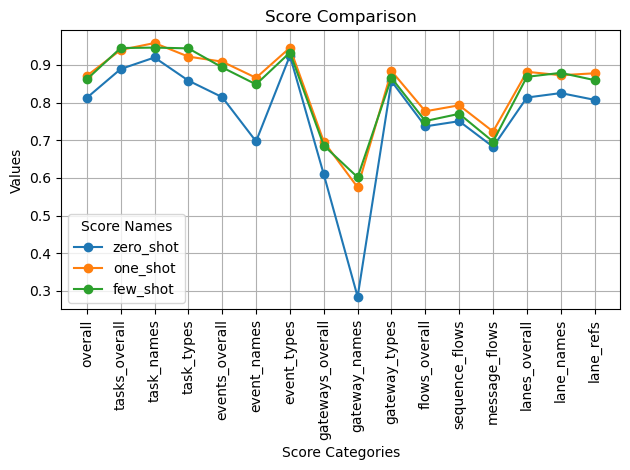

In [6]:
# lets plot these
import pandas as pd
import matplotlib.pyplot as plt

def plot_scores(scores, score_names, title):

    assert len(scores) == len(score_names)
    # Setting 'score_name' as the index
    for i in range(len(scores)):
        scores[i]["score_name"] = score_names[i]

    # Transform the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(scores)
    df.set_index('score_name', inplace=True)

    # Plotting as a line chart
    plt.figure(figsize=(10, 6))
    ax = df.T.plot(kind='line', marker='o')
    plt.title(title)
    plt.xlabel('Score Categories')
    plt.ylabel('Values')
    plt.grid(True)
    plt.legend(title='Score Names')
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90)
    plt.tight_layout()
    plt.show()


plot_scores([zeroshot_scores_mean.copy(), oneshot_scores_mean.copy(), fewshot_scores_mean.copy()], ["zero_shot", "one_shot", "few_shot"], "Score Comparison")

In [57]:
# and print it as a table
def print_scores_table(scores, score_names):

    assert len(scores) == len(score_names)
    # Setting 'score_name' as the index
    for i in range(len(scores)):
        scores[i]["score_name"] = score_names[i]
    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(scores)
    # Setting 'score_name' as the index if you want 'score_name' to be the first column instead of the index, you can skip this step
    df.set_index('score_name', inplace=True)
    # Transpose the DataFrame for better readability if your scores are in columns
    df = df.T
    pd.set_option('display.max_rows', None)  # or use a specific large number if you prefer
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)  
    print(df)

print_scores_table([zeroshot_scores_mean.copy(), oneshot_scores_mean.copy(), fewshot_scores_mean.copy()],  ["zero_shot", "one_shot", "few_shot"])


score_name          zero_shot  one_shot  few_shot
overall              0.812654  0.871079  0.861744
tasks_overall        0.889146  0.939833  0.944912
task_names           0.919780  0.958201  0.946046
task_types           0.858431  0.922100  0.944000
events_overall       0.814431  0.908772  0.893474
event_names          0.697021  0.865807  0.848409
event_types          0.924640  0.945658  0.932955
gateways_overall     0.609449  0.696482  0.686032
gateway_names        0.284444  0.575058  0.601764
gateway_types        0.856959  0.883706  0.865670
flows_overall        0.736907  0.776942  0.751045
sequence_flows       0.750651  0.792892  0.770219
message_flows        0.682600  0.723168  0.696521
lanes_overall        0.813442  0.881780  0.868453
lanes_without_refs   0.825298  0.872698  0.878962
lanes_with_refs      0.807339  0.877842  0.859720


In [58]:
# another table for the differences
zeroshot_minus_oneshot = zeroshot_scores_mean - oneshot_scores_mean
zeroshot_minus_fewshot = zeroshot_scores_mean - fewshot_scores_mean
oneshot_minus_fewshot = oneshot_scores_mean - fewshot_scores_mean

print_scores_table([zeroshot_minus_oneshot.copy(), zeroshot_minus_fewshot.copy(), oneshot_minus_fewshot.copy()],  ["zeroshot_minus_oneshot", "zeroshot_minus_fewshot", "oneshot_minus_fewshot"])

score_name          zeroshot_minus_oneshot  zeroshot_minus_fewshot  \
overall                          -0.058424               -0.049089   
tasks_overall                    -0.050686               -0.055765   
task_names                       -0.038422               -0.026267   
task_types                       -0.063669               -0.085570   
events_overall                   -0.094340               -0.079043   
event_names                      -0.168786               -0.151388   
event_types                      -0.021018               -0.008315   
gateways_overall                 -0.087034               -0.076583   
gateway_names                    -0.290613               -0.317320   
gateway_types                    -0.026747               -0.008711   
flows_overall                    -0.040035               -0.014138   
sequence_flows                   -0.042242               -0.019568   
message_flows                    -0.040569               -0.013921   
lanes_overall       

In [67]:
print(zeroshot_minus_oneshot.mean())
print(zeroshot_minus_fewshot.mean())
print(oneshot_minus_fewshot.mean())

-0.07555165472076529
-0.06667086327528615
0.008880791445479139


In [1]:
from multimodalgenai.evaluation.list_similarity import dice_SFA, make_similar_items_equal
TN_1 = ["Produce the car", "Test the car", "Fix the issue", "Ship the car"]
TN_2 = ["Produce a car", "Wash the car", "Fix the error", "Order the car"]
TT_1 = ["ServiceTask", "UserTask", "UserTask", "UserTask"]
TT_2 = ["ServiceTask", "ServiceTask", "ServiceTask", "ServiceTask"]
print(dice_SFA(TN_1, TN_2))
print(dice_SFA(TT_1, TT_2))
make_similar_items_equal(TN_1, TN_2)

c:\Users\I566116\AppData\Local\anaconda3\envs\multimodalgenai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(0.5, 2, 8)
(0.25, 1, 8)


([(('Produce the car', 'Produce a car', 0.9829292297363281),
   ('Produce the car', 'Produce a car', 0.9829292297363281),
   1.0),
  'Test the car',
  (('Fix the issue', 'Fix the error', 0.8842326998710632),
   ('Fix the issue', 'Fix the error', 0.8842326998710632),
   1.0000001192092896),
  'Ship the car'],
 [(('Produce the car', 'Produce a car', 0.9829292297363281),
   ('Produce the car', 'Produce a car', 0.9829292297363281),
   1.0),
  'Wash the car',
  (('Fix the issue', 'Fix the error', 0.8842326998710632),
   ('Fix the issue', 'Fix the error', 0.8842326998710632),
   1.0000001192092896),
  'Order the car'])

<Figure size 1000x600 with 0 Axes>

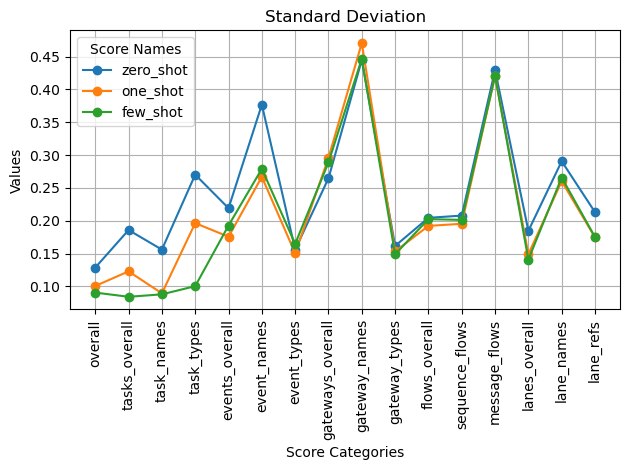

STD average over all the scores for Zero-Shot:  0.2433909788683253
STD average over all the scores for One-Shot:  0.21340097705965883
STD average over all the scores for Few-Shot:  0.20567587012525448


In [8]:
# lets look at standard deviations:
zeroshot_scores_std = df_zeroshot_scores.std()
oneshot_scores_std = df_oneshot_scores.std()
fewshot_scores_std = df_fewshot_scores.std()
zeroshot_scores_std_mean = zeroshot_scores_std.mean()
oneshot_scores_std_mean = oneshot_scores_std.mean()
fewshot_scores_std_mean = fewshot_scores_std.mean()
plot_scores([zeroshot_scores_std, oneshot_scores_std, fewshot_scores_std], ["zero_shot", "one_shot", "few_shot"], "Standard Deviation")
print("STD average over all the scores for Zero-Shot: ", zeroshot_scores_std_mean)
print("STD average over all the scores for One-Shot: ", oneshot_scores_std_mean)
print("STD average over all the scores for Few-Shot: ", fewshot_scores_std_mean)

0.2433909788683253


# Differences

generated vs ground_truth

gateway types:
Exclusive vs Exclusive_Databased_Gateway

event types:
Start vs StartNoneEvent
End vs EndNoneEvent



{('Invite to job interview0', 'Receive Application0'): 0.4881296753883362, ('Invite to job interview0', 'Verify Application0'): 0.2707115709781647, ('Invite to job interview0', 'Invite to job interview0'): 0.9999998807907104, ('Invite to job interview0', 'Prepare employment agreement0'): 0.37267154455184937, ('Invite to job interview0', 'Carry out job interview0'): 0.747755229473114, ('Invite to job interview0', 'Send employment contract0'): 0.4739527106285095, ('Invite to job interview0', 'Send rejection0'): 0.30742770433425903, ('Prepare employment agreement0', 'Receive Application0'): 0.2606421113014221, ('Prepare employment agreement0', 'Verify Application0'): 0.2961220145225525, ('Prepare employment agreement0', 'Invite to job interview0'): 0.37267154455184937, ('Prepare employment agreement0', 'Prepare employment agreement0'): 0.9999999403953552, ('Prepare employment agreement0', 'Carry out job interview0'): 0.38646310567855835, ('Prepare employment agreement0', 'Send employment 

<Figure size 1000x600 with 0 Axes>

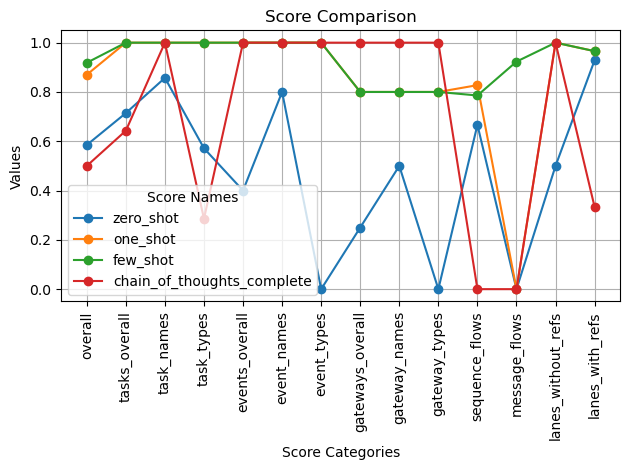

In [34]:
# lets look at chainofthoughts scores but only for the first index because we did not scaled it up yet
zeroshot_score_of_index_0  = get_score_from_index(0, "zero_shot")
zeroshot_score_of_index_0["score_name"] = "zero_shot"
oneshot_score_of_index_0  = get_score_from_index(0, "one_shot")
oneshot_score_of_index_0["score_name"] = "one_shot"
fewshot_score_of_index_0  = get_score_from_index(0, "few_shot")
fewshot_score_of_index_0["score_name"] = "few_shot"
chainofthoughts_score_of_index_0  = get_score_from_index(0, "chain_of_thoughts_complete")
chainofthoughts_score_of_index_0["score_name"] = "chain_of_thoughts_complete"

plot_scores([zeroshot_score_of_index_0, oneshot_score_of_index_0, fewshot_score_of_index_0, chainofthoughts_score_of_index_0])
